<a href="https://colab.research.google.com/github/algonzsen/DailyGym2/blob/master/ENTREGA_Proyecto_2_1_AED_en_un_Proceso_de_Galvanizado_de_Bobinas_de_Acero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- *Asignatura*: Ingeniería del Conocimiento
- *Curso*: 2020/2021
- *Profesor*: Fco. Javier Martínez de Pisón
- Universidad de La Rioja

# Proyecto 2. Diseño de DSS en Industria 4.0 (Parte 1/3)

En este ejemplo, como continuación del Proyecto 2, vamos a utlizar Python para profundizar en el desarrollo de modelos predictivos que puedan ser usados en una planta de galvanizado de bobinas de acero.

En este proyecto se pretende tener una experiencia cercana a aspectos propios de la Industria 4.0 como el Big Data y la Simulación.

![Industria 4.0](https://blog.wearedrew.co/hubfs/Industria-4-0.gif)

Lógicamente, el proceso de extracción, captura de la información y selección dentro de las miles de variables, ha sido realizado previamente. En nuestro caso, trabajaremos con una base de datos ya reducida y limpia, preparada para un contexto de aprendizaje. Esta Base de Datos está modificada para conservar la confidencialidad con la empresa.

Recordando lo visto en la primera parte de esta práctica, el objetivo consiste en desarrollar modelos que puedan ser utilizados para controlar y optimizar el proceso de recocido de una línea de galvanizado en continuo de bobinas de acero (línea de subida de la curva de recocido).
1. Caso A: Modelos de predicción de la temperatura de consigna del horno en la zona 1 del horno (THC1) según la temperatura de entrada de la banda, la temperatura a la que debe salir la banda, la velocidad de la banda, las dimensiones de la banda de acero y el tipo de acero de la misma.
2. Caso B: Modelo de predicción que permita predecir la temperatura de la banda de acero cuando sale del horno (TMPP2) según las temperaturas del horno (THC1, THC3 y THC5), la temperatura de entrada de la banda de acero (TMPP1), la velocidad de la banda (VELMED), dimensiones y tipo de acero.

![](http://templete.8directo.com/wp-content/uploads/sites/2/2018/02/Acerinox.jpg)

In [ ]:
# Importamos paquetes basicos
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff

## Cargamos la Base de Datos

In [ ]:
!wget https://github.com/IC1920/Datasets/raw/master/DATOS_HORNO_ENTRENA.arff -O DATOS_HORNO_ENTRENA.arff
!wget https://github.com/IC1920/Datasets/raw/master/DATOS_HORNO_TESTEO.arff -O DATOS_HORNO_TESTEO.arff

--2021-04-18 21:18:28--  https://github.com/IC1920/Datasets/raw/master/DATOS_HORNO_ENTRENA.arff
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IC1920/Datasets/master/DATOS_HORNO_ENTRENA.arff [following]
--2021-04-18 21:18:28--  https://raw.githubusercontent.com/IC1920/Datasets/master/DATOS_HORNO_ENTRENA.arff
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125832 (123K) [text/plain]
Saving to: ‘DATOS_HORNO_ENTRENA.arff’

DATOS_HORNO_ENTRENA 100%[===================>] 122.88K  --.-KB/s    in 0.01s   

2021-04-18 21:18:28 (11.7 MB/s) - ‘DATOS_HORNO_ENTRENA.arff’ saved [125832/125832]

--2021-04-18

In [ ]:
# Leemos los archivos arff
df_train = pd.DataFrame(arff.loadarff("DATOS_HORNO_ENTRENA.arff")[0])
df_test = pd.DataFrame(arff.loadarff("DATOS_HORNO_TESTEO.arff")[0])

In [ ]:
df_train.head()

,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
0,23293006.0,b'B011F97',1250.0,0.6,3683.0,21770.0,145.0,212.0,754.0,750.0,770.0,800.0,821.0
1,23293007.0,b'B011F97',1250.0,0.6,3040.0,18070.0,145.0,210.0,749.0,750.0,772.0,801.0,822.0
2,23293008.0,b'B011F97',1250.0,0.6,3605.0,21420.0,138.0,211.0,761.0,770.0,778.0,808.0,833.0
3,23293009.0,b'B011F97',1250.0,0.6,903.0,5330.0,145.0,221.0,755.0,750.0,758.0,788.0,811.0
4,23293010.0,b'B011F97',1250.0,0.6,2540.0,15030.0,105.0,223.0,752.0,750.0,752.0,783.0,806.0


Vemos que al leer nos han incluido un caracter 'b' en el código de la bobina y comillas simples. Procedemos a decodificarlo como formato *utf-8*.mando 'replace'

In [ ]:
# Convertimos la variable CLASACERO a utf-8
df_train['CLASACERO'] = df_train['CLASACERO'].str.decode('utf-8')
df_test['CLASACERO'] = df_test['CLASACERO'].str.decode('utf-8')
df_train.head()

,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
0,23293006.0,B011F97,1250.0,0.6,3683.0,21770.0,145.0,212.0,754.0,750.0,770.0,800.0,821.0
1,23293007.0,B011F97,1250.0,0.6,3040.0,18070.0,145.0,210.0,749.0,750.0,772.0,801.0,822.0
2,23293008.0,B011F97,1250.0,0.6,3605.0,21420.0,138.0,211.0,761.0,770.0,778.0,808.0,833.0
3,23293009.0,B011F97,1250.0,0.6,903.0,5330.0,145.0,221.0,755.0,750.0,758.0,788.0,811.0
4,23293010.0,B011F97,1250.0,0.6,2540.0,15030.0,105.0,223.0,752.0,750.0,752.0,783.0,806.0


La descripción de las variables de la base de datos es la siguiente:

-	CODBOB: Código de la bobina.
-	CLASACERO: Tipo de acero.
-	ANCHO: Ancho medio de la banda de acero. (mm)
-	ESPESOR: Espesor medio de la banda de acero. (mm).
-	LARGO: Largo medio de la banda de acero. (m).
-	PESO: Peso medio de la bobina. (Kg*10).
-	VELMED: Velocidad media de la banda de acero en el horno. (m/min)
-	TMPP1: Temperatura media de la banda de acero a la entrada del horno. (ºC)
-	TMPP2: Temperatura media de la banda de acero a la salida del horno. (ºC)
-	TMPP2CNG: Temperatura media objetivo que debería tener la banda de acero a la salida del horno. (ºC)
-	THC1: Temperatura media de consigna en la zona 1 del Horno. (ºC)
-	THC3: Temperatura media de consigna en la zona 3 del Horno. (ºC).
-	THC5: Temperatura media de consigna en la zona 5 del Horno. (ºC)

En este caso, los valores de temperatura del horno, de la banda de acero y de velocidad de la misma corresponden con los valores medios obtenidos para cada una de las bobinas.


In [ ]:
df_test.head()

,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
0,23633053.0,B105F55,1040.0,0.7,3491.0,19780.0,136.0,256.0,851.0,850.0,858.0,888.0,914.0
1,23633054.0,B105F55,1040.0,0.7,3240.0,18370.0,140.0,258.0,850.0,850.0,860.0,890.0,914.0
2,23633055.0,B105F55,1040.0,0.7,3047.0,17160.0,140.0,260.0,850.0,850.0,860.0,890.0,914.0
3,23633056.0,B105F55,1040.0,0.7,3513.0,19980.0,139.0,263.0,842.0,840.0,854.0,884.0,906.0
4,23643001.0,B100F55,1062.0,0.7,2949.0,17050.0,139.0,253.0,829.0,825.0,847.0,877.0,895.0


In [ ]:
np.unique(df_train['CLASACERO'])

array(['B011B99', 'B011F97', 'B012B97', 'B012F53', 'B012F55', 'B013B55',
       'B013C55', 'B014F53', 'B016F35', 'B023H53', 'B025F55', 'B032H53',
       'B042H53', 'B044H53', 'B081B99', 'B085F97', 'B085G99', 'B100B95',
       'B100F33', 'B100F55', 'B101F55', 'B102G33', 'B102G55', 'B103G33',
       'B103G55', 'B105F55', 'B120G55', 'C107G55', 'C114G55', 'C115G55',
       'C116G55', 'D012F55', 'D012G99', 'D031B33', 'D032F55', 'D071F55',
       'D094B33', 'D094G55', 'K011B55', 'K011F57', 'K021H43', 'K021H53',
       'K022H53', 'N013H53', 'N017B97', 'X100G99'], dtype=object)

También convertimos el código de la bobina a entero.

In [ ]:
df_train['CODBOB'] = df_train['CODBOB'].astype(int)
df_test['CODBOB'] = df_test['CODBOB'].astype(int)

display(df_train.head(3), df_test.head(3))

,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
0,23293006,B011F97,1250.0,0.6,3683.0,21770.0,145.0,212.0,754.0,750.0,770.0,800.0,821.0
1,23293007,B011F97,1250.0,0.6,3040.0,18070.0,145.0,210.0,749.0,750.0,772.0,801.0,822.0
2,23293008,B011F97,1250.0,0.6,3605.0,21420.0,138.0,211.0,761.0,770.0,778.0,808.0,833.0


,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
0,23633053,B105F55,1040.0,0.7,3491.0,19780.0,136.0,256.0,851.0,850.0,858.0,888.0,914.0
1,23633054,B105F55,1040.0,0.7,3240.0,18370.0,140.0,258.0,850.0,850.0,860.0,890.0,914.0
2,23633055,B105F55,1040.0,0.7,3047.0,17160.0,140.0,260.0,850.0,850.0,860.0,890.0,914.0


In [ ]:
df_train.shape, df_test.shape #Tamaño final de las bases de datos

((1898, 13), (81, 13))

## Análisis Exploratorio de Datos

In [ ]:
df_train.describe() # Describe variables numéricas

,CODBOB,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
count,1.894000e+03,1894.000000,1894.000000,1894.000000,1894.000000,1894.000000,1894.000000,1894.000000,1894.000000,1894.000000,1894.000000,1894.00000
mean,2.346878e+07,1176.050158,0.888018,2394.592397,17505.378036,106.711193,249.366420,807.428722,806.722809,815.522175,845.671595,865.07603
std,9.848034e+04,197.898244,0.347894,1043.070586,4999.865348,23.094823,19.783585,32.194781,32.368532,37.628544,38.238524,39.90981
min,2.329301e+07,750.000000,0.430000,350.000000,1380.000000,30.000000,200.000000,715.000000,725.000000,702.000000,734.000000,734.00000
25%,2.338304e+07,1000.000000,0.650000,1635.250000,14155.000000,87.000000,234.000000,790.000000,783.500000,795.000000,825.000000,840.00000
50%,2.346307e+07,1220.000000,0.770000,2187.500000,18700.000000,113.000000,250.000000,821.000000,825.000000,825.000000,854.000000,874.00000
75%,2.355304e+07,1301.000000,1.170000,3106.500000,21380.000000,125.000000,265.000000,826.000000,825.000000,844.000000,875.000000,894.75000
max,2.363305e+07,1525.000000,2.000000,5538.000000,26340.000000,145.000000,300.000000,867.000000,861.000000,877.000000,907.000000,932.00000


Vamos a ver la distribución de los datos para identificar valores anómalos

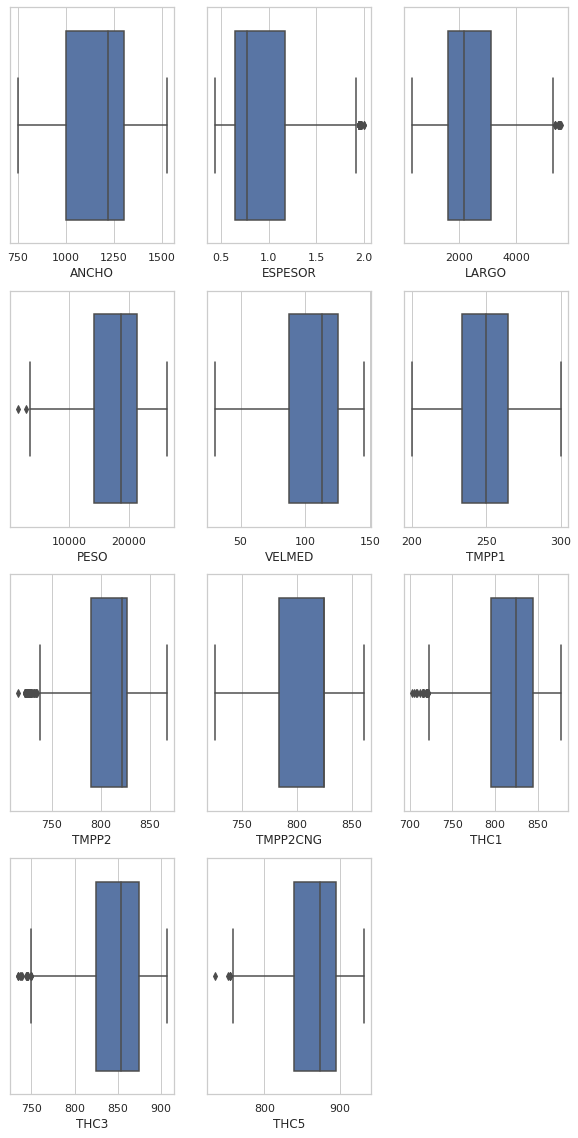

In [ ]:
# %config InlineBackend.figure_format = 'svg' # formato vectorial
fig = plt.figure(figsize=(10,20))
for ncol, columna in enumerate(df_train.columns[2:]):
    plt.subplot(4,3,ncol+1)
    sns.set(style="whitegrid")
    ax = sns.boxplot(x=df_train[columna], data=df_train)

Vemos algo extraño en la variable VELMED. Vamos a ver cuantos casos hay mayores de 500 metros por minuto y los eliminamos de la base de datos porque el proceso no permite velocidades de banda tan altas.

In [ ]:
np.sum(df_train['VELMED']>500)

0

In [ ]:
df_train = df_train.loc[df_train['VELMED']<500] # Nos quedamos con los casos menores de 500

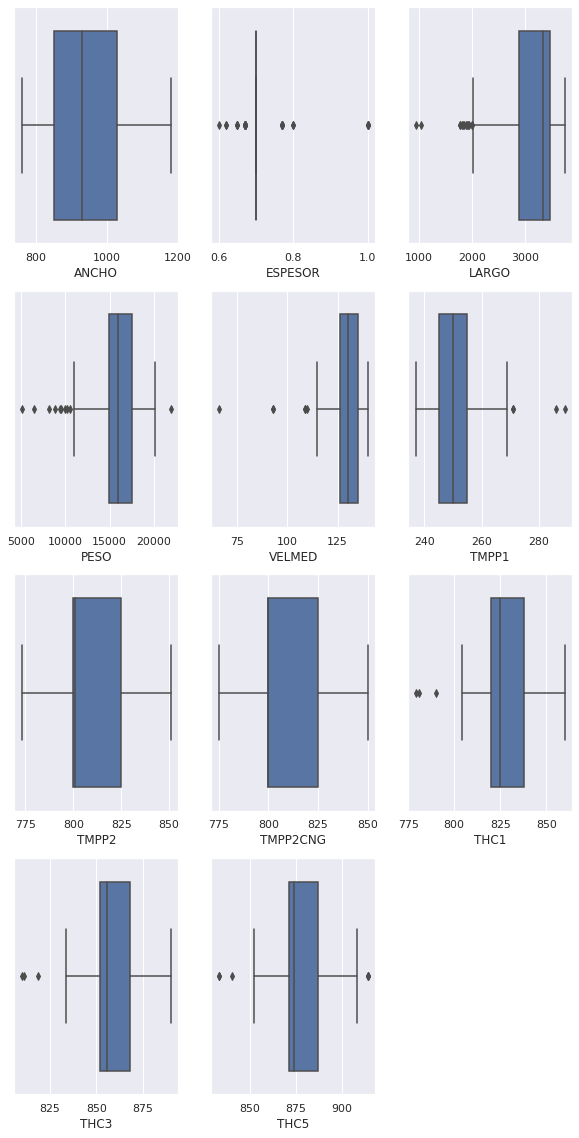

In [ ]:
# %config InlineBackend.figure_format = 'svg' # formato vectorial
sns.set(style="darkgrid")
fig = plt.figure(figsize=(10,20))
for ncol, columna in enumerate(df_test.columns[2:]):
    plt.subplot(4,3,ncol+1)
    ax = sns.boxplot(x=df_test[columna], data=df_train)

**EJERCICIO: Analiza los diagramas de cajas de las celdas anteriores y escribe tus conclusiones. Incluye el codigo que consideres necesario para justificar las mismas.**

In [ ]:
fig = plt.figure(figsize=(10,20))
plt.subplot(4,3,3)
ax = sns.boxplot(x=df_train["ANCHO"], data=df_train)

In [ ]:
fig = plt.figure(figsize=(10,20))
plt.subplot(4,3,3)
ax = sns.boxplot(x=df_test["ANCHO"], data=df_train)

In [ ]:
#Los bloques azules es donde mas datos hay. Las rayas es la mayoria y los puntos son los datos anómalos.
#El objetivo de tener dos bases de entreno y una de testeo es que los resultados salgan parecidos porque sino habre entrenado mal.
#Aqui observo que los datos no son iguales con los cual hemos tenido qu coger datos distintos. No he entrenado para esos datos de testeo

La base de datos de testeo aparentemente no tiene casos anómalos. Ahora, vamos a dibujar algunas variables.

In [ ]:
def dibuja_proceso(df, pos_ini = 0, num_bobs = None):
    if num_bobs==None:
        num_bobs = len(df)
    # Dibuja Espesor y Ancho con dos ejes
    # -----------------------------------
    df_plot = df.iloc[pos_ini:pos_ini+num_bobs]

    fig, ax = plt.subplots(constrained_layout=True, figsize=(10,4))
    ax.plot(df_plot['ESPESOR'], label='ESPESOR')
    ax.set_xlabel('Num. Bobina')
    ax.set_ylabel('Espesor (mm.)')
    # Segundo eje
    ax.plot(df_plot['ANCHO']/1000.0, label='ANCHO')
    def CtoF(x):
        return x * 1000.0
    def FtoC(x):
        return x / 1000.0

    secaxy = ax.secondary_yaxis('right', functions=(CtoF, FtoC))
    secaxy.set_ylabel('Ancho (mm.)')
    ax.legend()

    # Dibuja Temperaturas y Velocidad con dos ejes
    # -----------------------------------
    fig, ax = plt.subplots(constrained_layout=True, figsize=(10,6))
    for colname in df_plot.columns[7:]:
        ax.plot(df_plot[colname], label=colname)

    ax.set_xlabel('Num. Bobina')
    ax.set_ylabel('Temperaturas (ºC)')

    ax.plot(df_plot['VELMED']*3.0, label='VELMED')
    def CtoF(x):
        return x / 3.0
    def FtoC(x):
        return x * 3.0

    secaxy = ax.secondary_yaxis('right', functions=(CtoF, FtoC))
    secaxy.set_ylabel('Velocidad Media (m/min)')
    ax.legend()


In [ ]:
dibuja_proceso(df_train)

In [ ]:
dibuja_proceso(df_train, pos_ini=100, num_bobs=200)

In [ ]:
dibuja_proceso(df_test)

**EJERCICIO: Usando las funciones anteriores, visualiza tres momentos donde se produzcan cambios bruscos de velocidad y escribe tus conclusiones. Incluye el codigo que consideres necesario para justificar las mismas.**

In [ ]:
#Como he dicho anteriormente vemos que no cogen los mismos datos para entrenar que para testear porque los resultados no son parecidos
#En la de testeo veo cambios brucos de velocidad cerca de 70 y 80
#en la grafica vemos como la velocidad varía en funcion de las temperaturas de consgina 

Ahora mostramos la correlación entre features

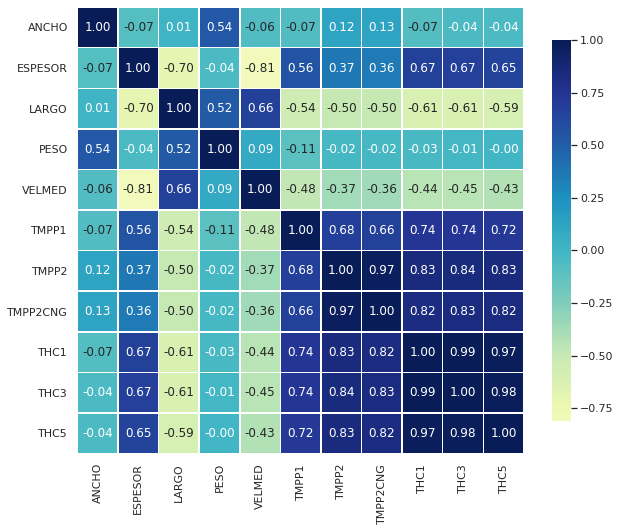

In [ ]:
cols = ['ANCHO', 'ESPESOR', 'LARGO', 'PESO', 'VELMED',
       'TMPP1', 'TMPP2', 'TMPP2CNG', 'THC1', 'THC3', 'THC5']
corr = df_train[cols].corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, vmax=1.0, center=0, fmt='.2f', square=True,
            linewidths=.5, annot=True, cbar_kws={"shrink":.7},
            cmap="YlGnBu")
#            xticklabels=corr.columns,
#            yticklabels=corr.columns,
#             cmap="YlGnBu")

**EJERCICIO: Usando la gráfica de correlaciones anterior identifica las variables con correlación elevada y explica por qué crees que tienen una correlación tan alta. Incluye el codigo que consideres necesario para justificar las mismas.**

In [ ]:
#Las correlaciones mas altas se dan entre las variables TMPP2 y TMPP2CNF con una correlación de 0.97. Entre estas hay una correlación alta porque la TMPP2 es la temperatura a la salida del horno
#y la TMPP2CNF es la temperatura media objetiva que deberia tener a la salida del horno, esto implica que deberia ser parecida.++
#También entre las THC1, THC3 Y THC5 hay unas correlaciones bastante altas de 0.99 entre THC1 y THC3 y de 0.97 entre THC1 y THC5.
#Entre THC3 y THC5 hay una correlacion de 0.98
#Entre estas hay una correlación alta prque todas son temperaturas medias de consigna pero en distintas zonas
#estas relaciones pueden conllevar que si cambia una variable estos cambios influyan en las demás

Vamos a dibujar el 'punto de operación' (PE) del proceso. El PE de un proceso o sistema es el estado en el que está el mismo en un momento de terminado. En el caso del proceso de galvanizado correspondería con la medición instantánea de las variables que influyen en el mismo. (velocidades, temperaturas, dimensiones del producto, etc.). De la proyección, vamos a eliminar algunas variables muy correladas entre si.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Seleccionamos variables eliminando aquellas muy correladas o que no explican el PE
cols_pca = ['ANCHO', 'ESPESOR', 'VELMED', 'TMPP1', 'TMPP2', 'THC1']

# Estandarizamos todas las columnas
scaler = StandardScaler()
scaler.fit(df_train[cols_pca])
df_train_esc = scaler.transform(df_train[cols_pca])
df_test_esc = scaler.transform(df_test[cols_pca])

# Sacamos los dos primeros componentes PCA para usarlos como ejes x e y
pca = PCA(n_components=2)
#pca = PCA(n_components=3)
pca.fit(df_train_esc)
print('Varianza explicada con los dos ejes:',np.sum(pca.explained_variance_ratio_))


Varianza explicada con los dos ejes: 0.7399525120297522


**EJERCICIO: ¿Son suficientes los dos primeros ejes del PCA según la varianza explicada? ¿Qué opinas?**

In [ ]:
#0.73 es un numero aceptable ppara la varianza ya que la varianza va a estar entre 0 y 1 siempre con lo cual el 73% podria ser suficiente. 
#si bien es cierto que si usamos 3 componente la varianza sube a 0.89 que es muy buena ya.

In [ ]:
# Graficamos los puntos de operación proyectados en los dos ejes principales del PCA
proyeccion = pca.transform(df_train_esc)
plt.figure(figsize=(8,8))
plt.scatter(proyeccion[:,0],proyeccion[:,1],alpha=0.50)
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.title('Proyección del Punto de Operación usando PCA')

In [ ]:
def saca_flechas(proyeccion, pos_ini=0, nump=10):
    proyec = proyeccion[pos_ini:pos_ini+nump]
    diff_proyec = np.diff(proyec,axis=0)

    plt.figure(figsize=(8,8))
    plt.scatter(proyeccion[:,0],proyeccion[:,1],alpha=0.10)
    plt.xlabel('PC0')
    plt.ylabel('PC1')
    plt.title('Recorrido del Punto de Operación usando PCA')
    for posrow in range(len(diff_proyec)):
        plt.arrow(x=proyec[posrow,0],y=proyec[posrow,1],
                  dx=diff_proyec[posrow,0],dy=diff_proyec[posrow,1],
                  color='red', linewidth=2.0,
                  head_width=0.1, head_length=0.1)

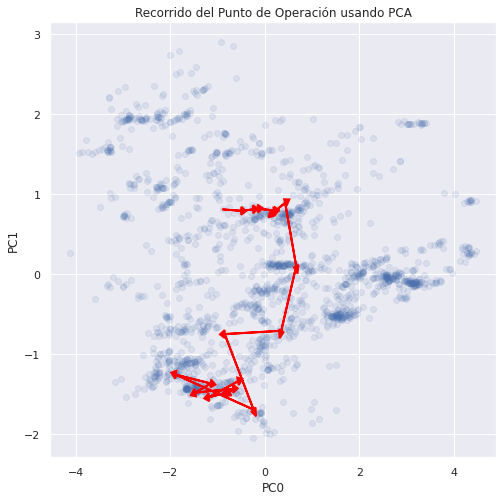

In [ ]:
saca_flechas(proyeccion,pos_ini=1010,nump=20)

**EJERCICIO: Usando las funciones anteriores busca otros dos momentos donde se produzcan cambios bruscos en el punto de operación y muéstralos con la funcion 'saca_flechas()'. Incluye el codigo que consideres necesario para justificar las mismas.**
    

In [ ]:
saca_flechas(proyeccion,pos_ini=1200,nump=20)

In [ ]:
saca_flechas(proyeccion,pos_ini=1500,nump=20)

**EJERCICIO: Crea una nueva función basada en 'saca_flechas()' para poder mostrar los puntos de operación de la base de datos de testeo encima de la proyeccion PCA de los puntos de entrenamiento. ¿Están en una zona diferente? ¿Qué pasaría si es así?**

Text(0.5, 1.0, 'Proyección del Punto de Operación usando PCA')

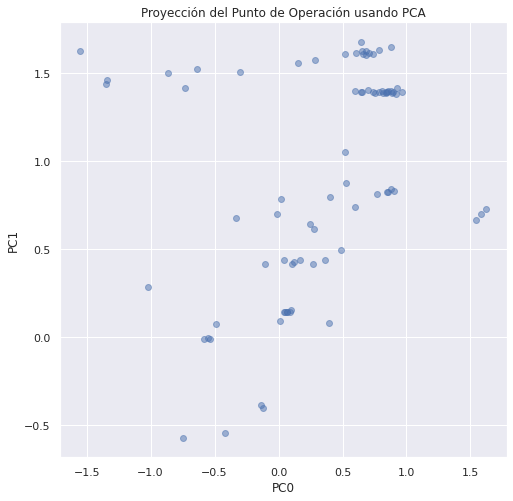

In [ ]:
proyeccion2 = pca.transform(df_test_esc)
plt.figure(figsize=(8,8))
plt.scatter(proyeccion2[:,0],proyeccion2[:,1],alpha=0.50)
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.title('Proyección del Punto de Operación usando PCA')

In [ ]:
def saca_flechas2(proyeccion1,proyeccion2, pos_ini=0, nump=10):
    proyec = proyeccion[pos_ini:pos_ini+nump]
    diff_proyec = np.diff(proyec,axis=0)

    plt.figure(figsize=(8,8))
    plt.scatter(proyeccion1[:,0],proyeccion[:,1],alpha=0.10)
    plt.scatter(proyeccion2[:,0],proyeccion2[:,1],alpha=0.10)
    plt.xlabel('PC0')
    plt.ylabel('PC1')
    plt.title('Recorrido del Punto de Operación usando PCA')
    for posrow in range(len(diff_proyec)):
        plt.arrow(x=proyec[posrow,0],y=proyec[posrow,1],
                  dx=diff_proyec[posrow,0],dy=diff_proyec[posrow,1],
                  color='red', linewidth=2.0,
                  head_width=0.1, head_length=0.1)

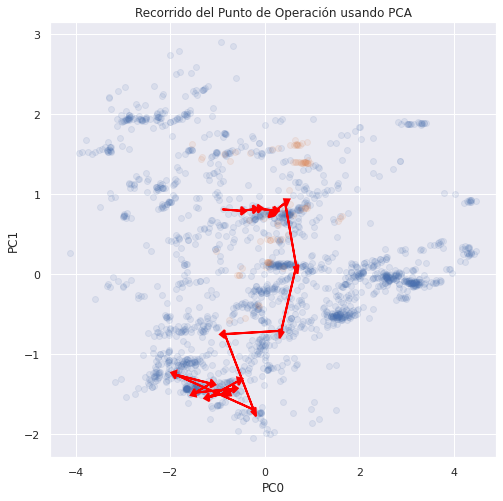

In [ ]:
saca_flechas2(proyeccion, proyeccion2,pos_ini=1010,nump=20)

In [ ]:
#vemos que son puntos diferentes ya que como se puede observar en la gráfica los datos de testeo son los puntos naranjas.

**EJERCICIO: Usa otros tipos de proyecciones (ISOMAP, LLE, MDS, T-SNE, etc.) para visualizar el punto de operación. Mínimo dos!**

In [ ]:
from sklearn.manifold import Isomap

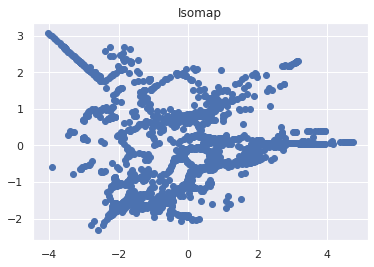

In [ ]:
Y = Isomap(n_neighbors=10, n_components=2).fit_transform(proyeccion)
plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
plt.title("Isomap")
plt.axis('tight')
plt.show()

In [ ]:
from sklearn.datasets import load_digits
from sklearn.manifold import MDS

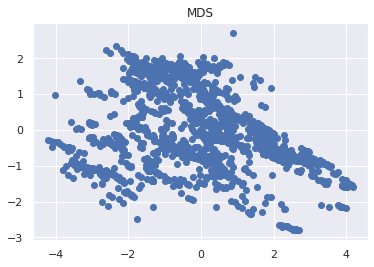

In [ ]:
Y = MDS().fit_transform(proyeccion)
plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
plt.title("MDS")
plt.axis('tight')
plt.show()

# ENTREGA

Recuerda guardar tus cambios en tu repositorio utilizando la opción "Save a copy in GitHub..." del menú File.